Mounted at /content/drive
Memeriksa ketersediaan GPU...
GPU tersedia! Training akan berjalan cepat.
80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


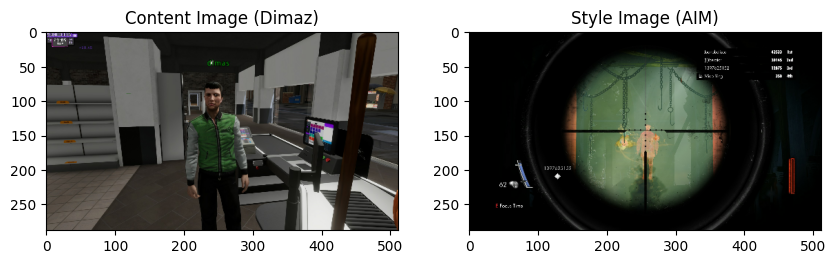

Mulai proses Style Transfer...
....................................................................................................
Epoch: 1/10


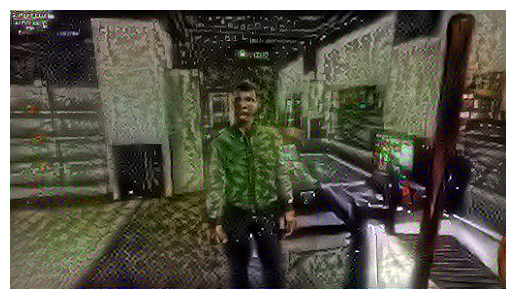

....................................................................................................
Epoch: 2/10


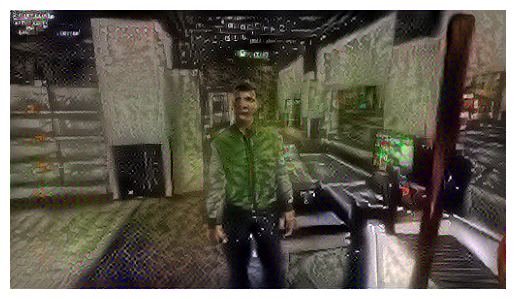

....................................................................................................
Epoch: 3/10


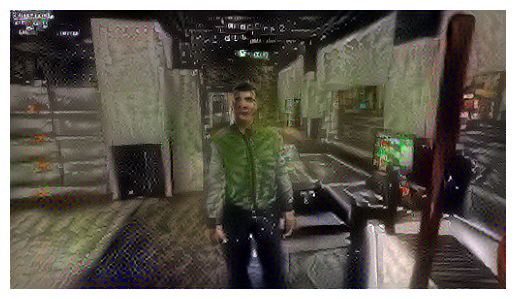

....................................................................................................
Epoch: 4/10


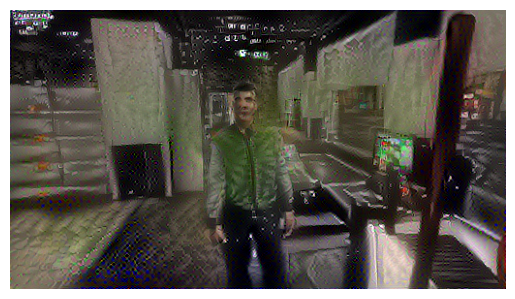

....................................................................................................
Epoch: 5/10


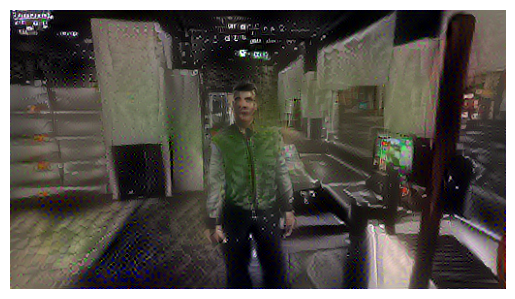

....................................................................................................
Epoch: 6/10


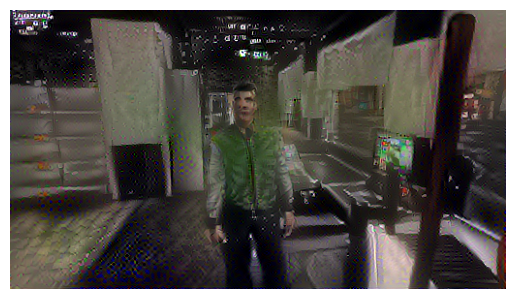

....................................................................................................
Epoch: 7/10


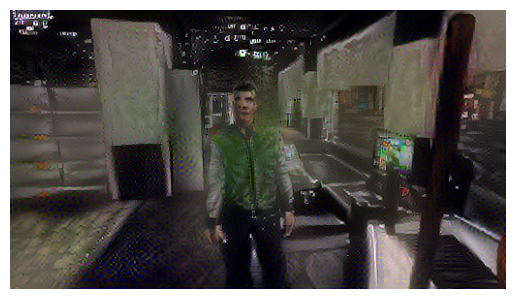

....................................................................................................
Epoch: 8/10


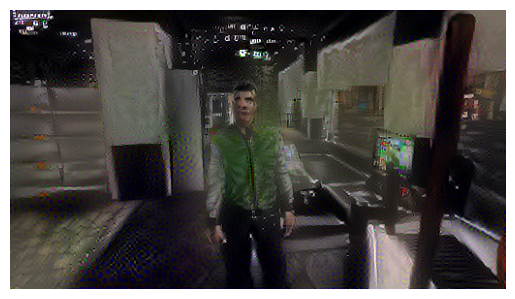

....................................................................................................
Epoch: 9/10


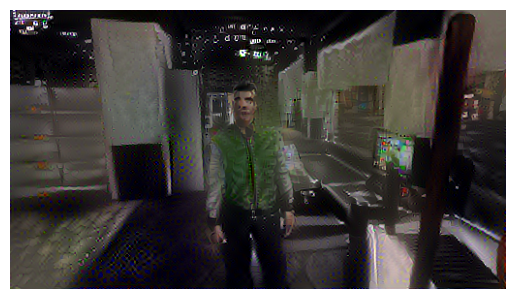

....................................................................................................
Epoch: 10/10


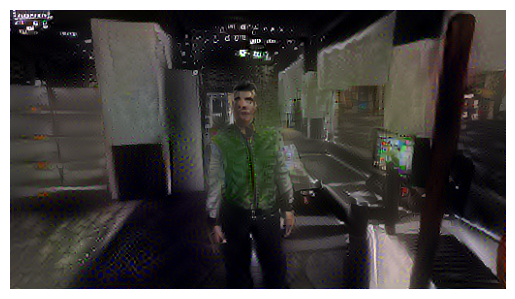

Selesai dalam: 54.3 detik
Gambar tersimpan di: /content/drive/MyDrive/AIPY/hasil_kombinasi.jpg


In [1]:
# -*- coding: utf-8 -*-
"""
Neural Style Transfer dengan VGG19
Dibuat untuk Google Colab
"""

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive
import os

# ==========================================
# 1. KONFIGURASI DAN MOUNT DRIVE
# ==========================================

# Mount Google Drive (Diperlukan karena path gambar ada di Drive)
if not os.path.exists('/content/drive'):
    drive.mount('/content/drive')

# Path Gambar sesuai permintaan
# Asumsi: 'dimaz.jpg' adalah foto asli (Content) dan 'AIM.jpg' adalah lukisan/gaya (Style)
# Jika terbalik, silakan tukar variabel di bawah ini.
content_path = '/content/drive/MyDrive/AIPY/dimaz.jpg'
style_path   = '/content/drive/MyDrive/AIPY/AIM.jpg'

# Parameter Hyperparameters
CONTENT_WEIGHT = 1e4  # Seberapa kuat mempertahankan bentuk asli
STYLE_WEIGHT   = 1e-2 # Seberapa kuat menerapkan gaya artistik
TOTAL_VARIATION_WEIGHT = 30 # Untuk menghaluskan hasil (mengurangi noise)
EPOCHS = 10
STEPS_PER_EPOCH = 100

print("Memeriksa ketersediaan GPU...")
if tf.config.list_physical_devices('GPU'):
    print("GPU tersedia! Training akan berjalan cepat.")
else:
    print("Peringatan: GPU tidak terdeteksi. Training akan lambat. Pastikan Runtime Type diubah ke GPU.")

# ==========================================
# 2. FUNGSI UTILITAS GAMBAR
# ==========================================

def load_img(path_to_img):
    """Memuat gambar dan mengubah ukurannya menjadi maksimal 512px."""
    max_dim = 512
    img = tf.io.read_file(path_to_img)
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)

    shape = tf.cast(tf.shape(img)[:-1], tf.float32)
    long_dim = max(shape)
    scale = max_dim / long_dim

    new_shape = tf.cast(shape * scale, tf.int32)

    img = tf.image.resize(img, new_shape)
    img = img[tf.newaxis, :] # Menambah dimensi batch
    return img

def imshow(image, title=None):
    """Menampilkan gambar tensor."""
    if len(image.shape) > 3:
        image = tf.squeeze(image, axis=0)
    plt.imshow(image)
    if title:
        plt.title(title)

# ==========================================
# 3. MODEL VGG19 & LOSS FUNCTIONS
# ==========================================

def vgg_layers(layer_names):
    """Membuat model VGG19 yang mengembalikan output dari layer perantara."""
    vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
    vgg.trainable = False

    outputs = [vgg.get_layer(name).output for name in layer_names]
    model = tf.keras.Model([vgg.input], outputs)
    return model

def gram_matrix(input_tensor):
    """Menghitung Gram Matrix untuk representasi gaya (style)."""
    result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
    input_shape = tf.shape(input_tensor)
    num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
    return result/(num_locations)

class StyleContentModel(tf.keras.models.Model):
    def __init__(self, style_layers, content_layers):
        super(StyleContentModel, self).__init__()
        self.vgg = vgg_layers(style_layers + content_layers)
        self.style_layers = style_layers
        self.content_layers = content_layers
        self.num_style_layers = len(style_layers)
        self.vgg.trainable = False

    def call(self, inputs):
        # Preprocessing input sesuai standar VGG19 (0-255 range)
        inputs = inputs * 255.0
        preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
        outputs = self.vgg(preprocessed_input)

        style_outputs, content_outputs = (outputs[:self.num_style_layers],
                                          outputs[self.num_style_layers:])

        style_outputs = [gram_matrix(style_output) for style_output in style_outputs]

        content_dict = {content_name: value for content_name, value in zip(self.content_layers, content_outputs)}
        style_dict = {style_name: value for style_name, value in zip(self.style_layers, style_outputs)}

        return {'content': content_dict, 'style': style_dict}

# ==========================================
# 4. EKSEKUSI TRAINING
# ==========================================

# Layer yang digunakan untuk Style dan Content
content_layers = ['block5_conv2']
style_layers = ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1']

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

# Inisialisasi Model
extractor = StyleContentModel(style_layers, content_layers)

# Memuat Gambar
try:
    content_image = load_img(content_path)
    style_image = load_img(style_path)

    # Menampilkan input
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    imshow(content_image, 'Content Image (Dimaz)')
    plt.subplot(1, 2, 2)
    imshow(style_image, 'Style Image (AIM)')
    plt.show()

except Exception as e:
    print(f"Error memuat gambar: {e}")
    print("Pastikan path gambar benar dan file ada di Google Drive.")
    # Stop eksekusi jika gambar tidak ditemukan
    raise e

# Menetapkan target
style_targets = extractor(style_image)['style']
content_targets = extractor(content_image)['content']

# Gambar awal adalah salinan dari content image
image = tf.Variable(content_image)

# Optimizer
opt = tf.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

def clip_0_1(image):
    return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

def style_content_loss(outputs):
    style_outputs = outputs['style']
    content_outputs = outputs['content']

    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2)
                           for name in style_outputs.keys()])
    style_loss *= STYLE_WEIGHT / num_style_layers

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2)
                             for name in content_outputs.keys()])
    content_loss *= CONTENT_WEIGHT / num_content_layers

    loss = style_loss + content_loss
    return loss

# Menggunakan tf.function untuk performa
@tf.function()
def train_step(image):
    with tf.GradientTape() as tape:
        outputs = extractor(image)
        loss = style_content_loss(outputs)
        loss += TOTAL_VARIATION_WEIGHT * tf.image.total_variation(image) # Smoothness

    grad = tape.gradient(loss, image)
    opt.apply_gradients([(grad, image)])
    image.assign(clip_0_1(image))

# Loop Utama
import time
start = time.time()

print("Mulai proses Style Transfer...")

for n in range(EPOCHS):
    for m in range(STEPS_PER_EPOCH):
        train_step(image)
        print(".", end='', flush=True)

    # Tampilkan progres setiap epoch
    print(f"\nEpoch: {n+1}/{EPOCHS}")
    plt.imshow(tf.squeeze(image, axis=0))
    plt.axis('off')
    plt.show()

end = time.time()
print(f"Selesai dalam: {end-start:.1f} detik")

# Simpan Hasil
result_path = '/content/drive/MyDrive/AIPY/hasil_kombinasi.jpg'
tf.keras.preprocessing.image.save_img(result_path, tf.squeeze(image, axis=0))
print(f"Gambar tersimpan di: {result_path}")

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
